## Jupyter Notebook : Text Clustering 

#### - Adirtha Borgohain

In [52]:
## Import all necessary libraries and modules
import math
import string
import gensim
import numpy as np
import numpy.matlib
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation
%matplotlib inline

In [2]:
DATA_DIR = './'
FILE_NAME = 'text_to_cluster.txt'
delimiter = '\n'

In [3]:
## Reading the data file
df = pd.read_csv(DATA_DIR + FILE_NAME, delimiter=delimiter, header=None, names=["Headlines"])
df.head()

,Headlines
0,Ransomware attack at Mexico's Pemex halts work...
1,#city | #ransomware | Ransomware Attack At Mex...
2,"Mexico's Pemex Oil Suffers Ransomware Attack, ..."
3,A Mexican oil company was hit by ransomware at...
4,Pemex Struck by Ransomware Attack


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684 entries, 0 to 683
Data columns (total 1 columns):
Headlines    684 non-null object
dtypes: object(1)
memory usage: 5.5+ KB


In [5]:
## Cleaning the text in headlines

filter_text = string.punctuation + '“”|”' + string.digits

df['Filter_Headlines'] = df['Headlines'].apply(lambda x: x.lower())
df['Filter_Headlines'] = df['Filter_Headlines'].apply(lambda x: x.translate(str.maketrans(filter_text,' '*len(filter_text),'')))
df_list = df['Filter_Headlines'].values

I used word embeddings in order to convert each of the word in our vocabulary to vectors. I downloaded pre-trained glove embeddings from *twitter27b* where each vector is of dimension 100. Once I load the word vectors to my gensim model, I tokenize each of the sentences into their words and find out the respective vectors for each word. In order to vectorize a complete sentence, I took the mean of each element of the word-vectors of a sentence in order to derive a single 100 dimension vector.

In [6]:
word_list = []
for line in df_list:
    temp_list = []
    for word in line.split():
        temp_list.append(word)
    word_list.append(temp_list)

In [7]:
def sent_vectorizer(sent, model):
    sent_vec =[]
    numw = 0
    for w in sent:
        try:
            if numw == 0:
                sent_vec = model[w]
            else:
                sent_vec = np.add(sent_vec, model[w])
            numw+=1
        except:
            pass
     
    return np.asarray(sent_vec) / numw

In [8]:
## This cell is only to be executed once when we convert the pre-trained vector file format from 
## glove to word2vec format inorder to load it to our model

### Word-vectors downloaded from: 
###      https://www.kaggle.com/bertcarremans/glovetwitter27b100dtxt#glove.twitter.27B.100d.txt
### I have not included it in the zip file because the size is of 1 gb.
    
# from gensim.scripts.glove2word2vec import glove2word2vec
# glove2word2vec('glove.twitter.27B.100d.txt', 'glove27B.txt')

In [9]:
## Loading the model
model = gensim.models.KeyedVectors.load_word2vec_format('glove27B.txt', binary=False) 

In [10]:
X = []
for sentence in tqdm(word_list):
    X.append(sent_vectorizer(sentence, model))
X = np.array(X)

100%|██████████| 684/684 [00:00<00:00, 39716.81it/s]


In [11]:
X.shape

(684, 100)

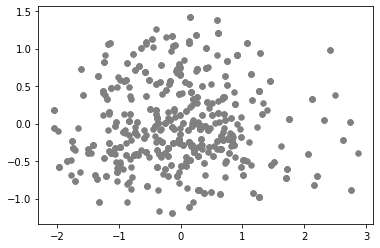

In [12]:
## We take a look at the distribution of the data after reducing the vectors to 2-dimensions through PCA
sklearn_pca = PCA(n_components = 2)
Y_PCA = sklearn_pca.fit_transform(X)
plt.scatter(Y_PCA[:, 0], Y_PCA[:, 1], c='grey', s=30)

### Defining the model and getting its results

In [53]:
clf = AffinityPropagation()
clf.fit(X)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
                    damping=0.5, max_iter=200, preference=None, verbose=False)

In [56]:
n_clusters = max(clf.labels_)

81

In [61]:
cluster_dict = {i: np.where(clf.labels_ == i)[0] for i in range(n_clusters)}
cluster_dict

{0: array([  0,   1,   7,  10, 184, 186, 187, 198, 259, 303, 304, 306, 559,
        568, 647, 651]),
 1: array([  2,   4, 189, 190, 194, 300, 301, 302, 308, 609, 611]),
 2: array([ 12,  99, 201, 282]),
 3: array([ 14,  15,  17,  21,  32, 176, 234, 235, 238, 240, 250, 251, 346,
        357, 386, 461, 470, 596, 598]),
 4: array([ 16,  23,  26,  94, 125, 214, 219, 236, 244, 246, 252, 278, 459,
        466, 479]),
 5: array([ 18,  54, 340, 415, 471, 503, 513, 523, 618]),
 6: array([ 20, 216, 321, 350, 363, 495]),
 7: array([ 25, 239, 245, 462, 465]),
 8: array([ 13,  22,  29,  34, 215, 241, 243, 248, 253, 254, 255, 463, 464,
        469, 604, 681]),
 9: array([ 30,  42,  67, 174, 177, 178, 220, 249, 266, 345, 358, 403, 410,
        424, 474, 526]),
 10: array([ 31, 213, 337, 408, 535]),
 11: array([ 35, 217, 223, 256, 257, 285, 366, 484, 485, 486, 487, 679]),
 12: array([ 36, 100, 393, 507, 620]),
 13: array([ 38,  45,  51,  52, 102, 107, 113, 114, 476, 527, 617]),
 14: array([ 33,  40, 10

In [63]:
## A txt outfile file is created and the results are written to it as needed
output_file = open("output-Affinity.txt","w") 

for key,value in cluster_dict.items():
    output_file.write('cluster id: ' + str(key) + '\n')
    for i in value:
        output_file.write(df['Headlines'].iloc[i] + '\n')
    output_file.write('*' * 100)
    output_file.write('\n')